*There are so many duplicates that MM is now doing worse after

In [1]:
import os
import mokapot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
sys.path
import data_loader as dl

This takes the 'before' data and filters it by dropping decoys and duplicates. Mokapot needs deocys, so they are only removed from 'before' data

In [1]:
def filter_data(df, prob_column='QValue'):
    #drop decoys
    df = df[df["decoy"]==False]
    #sort by qvalue
    df = df.sort_values(prob_column)
    #Drop duplicates
    df = df.drop_duplicates(subset=["scan"], keep="first") #keep highest scoring

    return df

Because the pin files do not have a qvalue, we need to use the psmtsv output file to get the number of psms under the cutoff for the native data

In [3]:
def get_PreMokaPot_data(file):
    mm_df = dl.clean_metamorph(file)
    mm_df = filter_data(mm_df,"QValue")
    return mm_df


Reading in the data. MetaMorpheus gives an output file that is specifically designed for Percolator, that's the file we are using here.

In [4]:
def get_data_for_MokaPot(file):
    df = dl.get_pin_file(file)

    #Dropping because this is not a a real row
    df = df.iloc[1: :]
    
    #Drop duplicates
    df = df.drop_duplicates(subset=["ScanNr"], keep="first") #keep highest scoring
    
    return df

Using code from MokaPot to generate a graph that compares pre and post mokapot data.

In [5]:
def plot_qvalues(qvalues, threshold=0.01, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # Calculate cumulative targets at each q-value
    qvals = pd.Series(qvalues, name="qvalue")
    qvals = qvals.sort_values(ascending=True).to_frame()
    qvals["target"] = 1
    qvals["num"] = qvals["target"].cumsum()
    qvals = qvals.groupby(["qvalue"]).max().reset_index()
    qvals = qvals[["qvalue", "num"]]

    zero = pd.DataFrame({"qvalue": qvals["qvalue"][0], "num": 0}, index=[-1])
    qvals = pd.concat([zero, qvals], sort=True).reset_index(drop=True)

    xmargin = threshold * 0.05
    ymax = qvals.num[qvals["qvalue"] <= (threshold + xmargin)].max()
    ymargin = ymax * 0.05

    # Set margins
    curr_ylims = ax.get_ylim()
    if curr_ylims[1] < ymax + ymargin:
        ax.set_ylim(0 - ymargin, ymax + ymargin)

    ax.set_xlim(0 - xmargin, threshold + xmargin)
    ax.set_xlabel("q-value")
    ax.set_ylabel(f"Discoveries")

    ax.step(qvals["qvalue"].values, qvals.num.values, where="post", **kwargs)

    return ax

In [6]:
def plot_qvalues(qvalues, threshold=0.01, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # Calculate cumulative targets at each q-value
    qvals = pd.Series(qvalues, name="qvalue")
    qvals = qvals.sort_values(ascending=True).to_frame()
    qvals["target"] = 1
    qvals["num"] = qvals["target"].cumsum()
    qvals = qvals.groupby(["qvalue"]).max().reset_index()
    qvals = qvals[["qvalue", "num"]]

    zero = pd.DataFrame({"qvalue": qvals["qvalue"][0], "num": 0}, index=[-1])
    qvals = pd.concat([zero, qvals], sort=True).reset_index(drop=True)

    xmargin = threshold * 0.05
    ymax = qvals.num[qvals["qvalue"] <= (threshold + xmargin)].max()
    ymargin = ymax * 0.05

    # Set margins
    curr_ylims = ax.get_ylim()
    if curr_ylims[1] < ymax + ymargin:
        ax.set_ylim(0 - ymargin, ymax + ymargin)

    ax.set_xlim(0 - xmargin, threshold + xmargin)
    ax.set_xlabel("q-value")
    ax.set_ylabel(f"Discoveries")

    ax.step(qvals["qvalue"].values, qvals.num.values, where="post", **kwargs)

    return ax

Here we are going to start our data processing

We have to get the 'before' data. It is from a 2 ng file from metamorpheus.
We have to use a different file for 'before' than the one we send to mokapot, because
the one we send to mokapot does not have any probability values.

In [7]:
file_names = ["2ng_rep1", "2ng_rep2", "2ng_rep3", "2ng_rep4", "2ng_rep5", "2ng_rep6",
             "0.2ng_rep1", "0.2ng_rep2", "0.2ng_rep3", "0.2ng_rep4", "0.2ng_rep5", "0.2ng_rep6"]

Now we're getting a data file to send into mokapot

In [8]:
for file in file_names:
    mm_df = get_PreMokaPot_data(file)
    df = get_data_for_MokaPot(file)
    psms = mokapot.read_pin(df)
    results, models = mokapot.brew(psms)
    results_df = results.psms
    results_df.to_csv("MokaPot_Output/MetaMorpheus/mm_" + file + ".csv")
    
    print("The number of PSMs found at or above 0.01 for " + file + ":")   
    print("\t" + "MetaMorpheus: " + str(len(mm_df[mm_df['QValue'] <= 0.01])))
    print("\t""MetaMorpheus and MokaPot: " + str(len(results.psms[results.psms['mokapot q-value'] <= 0.01])))

/Users/daishavanderwatt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The number of PSMs found at or above 0.01 for 2ng_rep1:
	MetaMorpheus: 12446
	MetaMorpheus and MokaPot: 14601


/Users/daishavanderwatt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (11,19,20,21,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The number of PSMs found at or above 0.01 for 2ng_rep2:
	MetaMorpheus: 12699
	MetaMorpheus and MokaPot: 14370


/Users/daishavanderwatt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (11,19,21,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The number of PSMs found at or above 0.01 for 2ng_rep3:
	MetaMorpheus: 10914
	MetaMorpheus and MokaPot: 12269


/Users/daishavanderwatt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The number of PSMs found at or above 0.01 for 2ng_rep4:
	MetaMorpheus: 10742
	MetaMorpheus and MokaPot: 12035


/Users/daishavanderwatt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (11,19,20,21,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The number of PSMs found at or above 0.01 for 2ng_rep5:
	MetaMorpheus: 15385
	MetaMorpheus and MokaPot: 16756


/Users/daishavanderwatt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The number of PSMs found at or above 0.01 for 2ng_rep6:
	MetaMorpheus: 14611
	MetaMorpheus and MokaPot: 15752
The number of PSMs found at or above 0.01 for 0.2ng_rep1:
	MetaMorpheus: 6736
	MetaMorpheus and MokaPot: 7156
The number of PSMs found at or above 0.01 for 0.2ng_rep2:
	MetaMorpheus: 6706
	MetaMorpheus and MokaPot: 6838
The number of PSMs found at or above 0.01 for 0.2ng_rep3:
	MetaMorpheus: 5020
	MetaMorpheus and MokaPot: 5394
The number of PSMs found at or above 0.01 for 0.2ng_rep4:
	MetaMorpheus: 4698
	MetaMorpheus and MokaPot: 5160
The number of PSMs found at or above 0.01 for 0.2ng_rep5:
	MetaMorpheus: 5156
	MetaMorpheus and MokaPot: 5551
The number of PSMs found at or above 0.01 for 0.2ng_rep6:
	MetaMorpheus: 4760
	MetaMorpheus and MokaPot: 5273


Graphing the results from the data comparing it before it was run through MokaPot versus after it was run through MokaPot

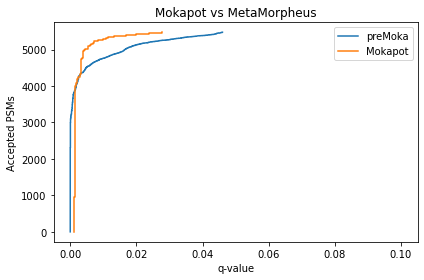

In [9]:
plot_qvalues(mm_df["QValue"], label="Pre-mokapot")
plt.title("Mokapot vs MetaMorpheus")
results.plot_qvalues(label="mokapot")
plt.legend(["preMoka", "Mokapot"])
#plt.vlines(x = 0.01, ymin = 0, ymax = 16000)
plt.tight_layout()

plt.show()

In [10]:
print("The number of PSMs found at or above 0.01: ") 
      
print("\t" + "MetaMorpheus: " + str(len(mm_df[mm_df['QValue'] <= 0.01])))

print("\t""MetaMorpheus and MokaPot: " + str(len(results.psms[results.psms['mokapot q-value'] <= 0.01])))

The number of PSMs found at or above 0.01: 
	MetaMorpheus: 4760
	MetaMorpheus and MokaPot: 5273


In [11]:
df = dl.get_pin_file("2ng_rep1")
df = df.iloc[1: :]
print(len(df))
drop_df = df.drop_duplicates(subset=["ScanNr"], keep="first")
print(len(df) - len(drop_df))


24109
8058


In [12]:
mm_df = dl.clean_metamorph("2ng_rep1")
print(len(mm_df))
mm_df1 = filter_data(mm_df,"QValue")

print(len(mm_df)-len(mm_df1))


/Users/daishavanderwatt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


21701
6166


In [13]:
#What scan nums are in the pin that are not in our file. look at the qval. Might need to look at mzml file. 